# Fashion-MNIST: Training und Inferenz mit CNN

Dieses Notebook zeigt, wie ein einfaches Convolutional Neural Network (CNN) auf Fashion-MNIST trainiert und für Vorhersagen genutzt wird.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Fashion-MNIST Daten laden
transform = transforms.Compose([
    transforms.ToTensor()
])
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:05<00:00, 4.86MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.58MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.56MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.4MB/s]


In [7]:
def train_model(model, train_loader, epochs=5, lr=0.001, device='cpu'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    print("Training finished.")
    return model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=10)
trained_model = train_model(model, trainloader, epochs=5, lr=0.001, device=device)
# Modell speichern
torch.save(trained_model.state_dict(), 'fashion_mnist_cnn.pth')
print('Modell gespeichert als fashion_mnist_cnn.pth')

Epoch 1/5, Loss: 0.4675
Epoch 2/5, Loss: 0.2971
Epoch 2/5, Loss: 0.2971
Epoch 3/5, Loss: 0.2548
Epoch 3/5, Loss: 0.2548
Epoch 4/5, Loss: 0.2232
Epoch 4/5, Loss: 0.2232
Epoch 5/5, Loss: 0.2005
Training finished.
Modell gespeichert als fashion_mnist_cnn.pth
Epoch 5/5, Loss: 0.2005
Training finished.
Modell gespeichert als fashion_mnist_cnn.pth


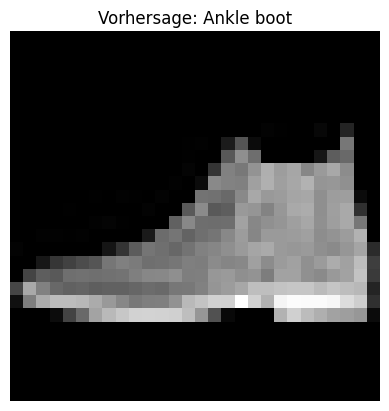

In [9]:
FASHION_LABELS = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def predict_image(model, image_tensor, device='cpu'):
    model.eval()
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted.item(), FASHION_LABELS[predicted.item()]

# Beispiel: Vorhersage für ein Testbild
model = SimpleCNN(num_classes=10)
model.load_state_dict(torch.load('fashion_mnist_cnn.pth', map_location=device))
model.to(device)
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0].unsqueeze(0)
pred_idx, pred_label = predict_image(model, img, device)
plt.imshow(img.cpu().squeeze(), cmap='gray')
plt.title(f'Vorhersage: {pred_label}')
plt.axis('off')
plt.show()